# <center>EXPLORATORY DATA ANALYSIS

In [1]:
#import the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

In [2]:
#load the clean csv after data cleaning anf feature engineering
df = pd.read_csv('u5mr_clean.csv')
df.head()

,CASEID,Respondents current age,Region,Type of place of residence,Highest educational level,Religion,Ethnicity,Number of household members (listed),Wealth index combined,"Type of cooking fuel (smoke exposure, indoor air pollution)",...,Received inactivated polio (IPV)_missing,Received Rotavirus 2_missing,Place where most vaccinations were received_missing,Yellow fever vaccine_missing,Given child anything other than breast milk_missing,Visited health facility last 12 months_missing,Getting medical help for self: distance to health facility_missing,Mode of transportation to nearest healthcare facility_missing,prenatal_help_missing,delivery_help_missing
0,1 4 2,34.0,1.0,1.0,0.0,7.0,11.0,6,4.0,2.0,...,0,0,0,1,0,0,0,0,0,0
1,1 13 2,39.0,1.0,1.0,2.0,1.0,3.0,8,5.0,2.0,...,1,1,1,1,1,0,0,0,1,1
2,1 26 2,28.0,1.0,1.0,2.0,3.0,3.0,5,4.0,2.0,...,1,1,1,1,1,0,0,0,1,1
3,1 42 1,30.0,1.0,1.0,2.0,4.0,3.0,3,5.0,2.0,...,1,1,1,1,1,1,1,1,1,1
4,1 55 2,34.0,1.0,1.0,2.0,2.0,3.0,4,5.0,2.0,...,0,0,0,1,1,1,1,1,0,0


In [3]:
df.select_dtypes(['object','category'])

,CASEID,mortality_category,prenatal_help,delivery_help
0,1 4 2,Alive or 5+,1,1
1,1 13 2,Alive or 5+,1,1
2,1 26 2,Alive or 5+,1,1
3,1 42 1,Alive or 5+,1,1
4,1 55 2,Alive or 5+,1,1
...,...,...,...,...
19525,1692 18 2,Alive or 5+,1,1
19526,1692 18 2,Alive or 5+,1,1
19527,1692 66 2,Alive or 5+,1,1
19528,1692 84 2,Alive or 5+,1,1


We will proceed with exploratory data analysis, where we will explore the mortality figures in neonates, infants and children aged 1-5 using visualizations.

## Mortality Plots

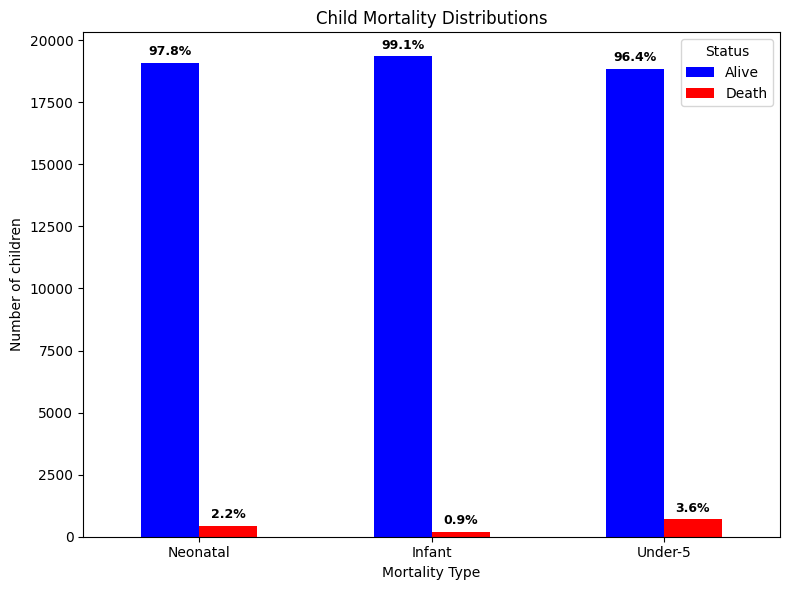

In [4]:
#Plot Child Mortality Distributions
# Prepare data
mortality_cols = {
    "neonatal_mortality": "Neonatal",
    "infant_mortality": "Infant",
    "under5_mortality": "Under-5"
}

counts = pd.DataFrame({
    label: df[col].value_counts().sort_index()
    for col, label in mortality_cols.items()
}).T

# Ensure Alive=0, Death=1 order
counts = counts[[0, 1]]
counts.columns = ["Alive", "Death"]

# Plot grouped bar chart
ax = counts.plot(
    kind="bar",
    stacked=False,
    color=["blue", "red"],
    figsize=(8, 6)
)

# Add percentage labels correctly using bar containers
for container in ax.containers:
    # Get group total per mortality type
    for bar in container:
        height = bar.get_height()
        if height > 0:
            # Total of the group (Alive+Death)
            total = counts.loc[bar.get_x() + bar.get_width()/2, :].sum() if False else None
        # Better way: use index position
    for i, bar in enumerate(container):
        height = bar.get_height()
        if height > 0:
            total = counts.iloc[i].sum()
            pct = height / total * 100
            ax.text(
                bar.get_x() + bar.get_width()/2,
                height + total * 0.01,
                f"{pct:.1f}%",
                ha='center', va='bottom',
                fontsize=9, fontweight="bold"
            )

plt.ylabel("Number of children")
plt.xlabel("Mortality Type")
plt.title("Child Mortality Distributions")
plt.xticks(rotation=0)
plt.legend(title="Status")
plt.tight_layout()
plt.show()

As can be seen in the bar chart above, the highest mortality rate is in the under 5 group, with a mortality rate of 3.6%, followed by neonates at 2.2% and 0.9% in the infants.

## Demographics and Household Analysis

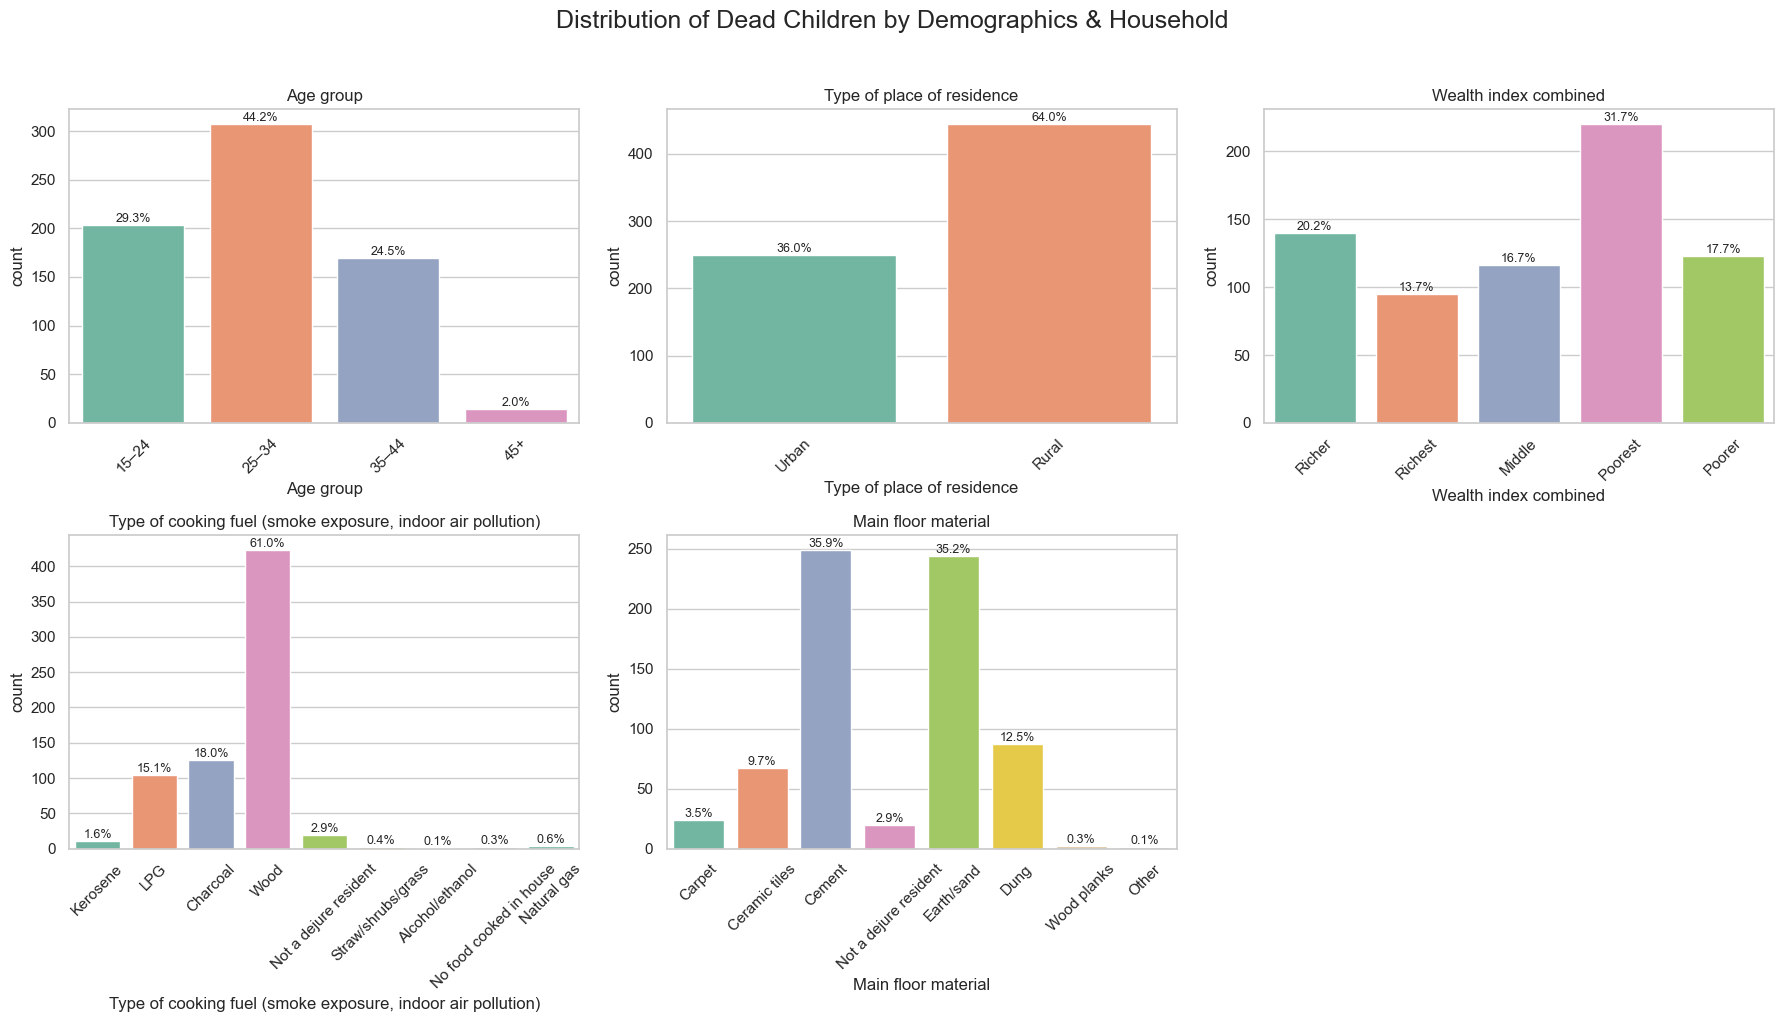

In [5]:
# Filter only mortality==1
# Make age categorical
age_bins = [15, 25, 35, 45, 55]  # adjust as needed
age_labels = ["15–24", "25–34", "35–44", "45+"]
df["Age group"] = pd.cut(df["Respondents current age"], bins=age_bins, labels=age_labels, right=False)

df_dead = df[df["under5_mortality"] == 1].copy()

# Define mappings
residence_map = {1: "Urban", 2: "Rural"}
wealth_map = {1: "Poorest", 2: "Poorer", 3: "Middle", 4: "Richer", 5: "Richest"}
cooking_map = {
    1: "Electricity", 2: "LPG", 3: "Natural gas", 4: "Biogas", 5: "Kerosene",
    6: "Coal/lignite", 7: "Charcoal", 8: "Wood", 9: "Straw/shrubs/grass",
    10: "Agricultural crop", 11: "Animal dung", 12: "Alcohol/ethanol",
    13: "Gasoline/diesel", 14: "Solar Power", 95: "No food cooked in house",
    96: "Other", 97: "Not a dejure resident"
}
floor_map = {
    10: "NATURAL", 11: "Earth/sand", 12: "Dung",
    20: "RUDIMENTARY", 21: "Wood planks", 22: "Palm/bamboo",
    30: "FINISHED", 31: "Parquet/polished wood", 32: "Vinyl/asphalt",
    33: "Ceramic tiles", 34: "Cement", 35: "Carpet",
    96: "Other", 97: "Not a dejure resident"
}

# Apply mappings
df_dead["Type of place of residence"] = df_dead["Type of place of residence"].map(residence_map)
df_dead["Wealth index combined"] = df_dead["Wealth index combined"].map(wealth_map)
df_dead["Type of cooking fuel (smoke exposure, indoor air pollution)"] = df_dead["Type of cooking fuel (smoke exposure, indoor air pollution)"].map(cooking_map)
df_dead["Main floor material"] = df_dead["Main floor material"].map(floor_map)

# Variables
variables = [
    "Age group",
    "Type of place of residence",
    "Wealth index combined",
    "Type of cooking fuel (smoke exposure, indoor air pollution)",
    "Main floor material"
]

# Plot setup
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    g = sns.countplot(
        data=df_dead,
        x=var,
        hue=var,              
        palette="Set2",       #colors applied per category
        dodge=False,          #prevents splitting bars (keeps single bar per category)        
        ax=axes[i]
    )
    
    # Rotate labels
    g.set_title(var)
    g.tick_params(axis='x', rotation=45)
    
    # Add percentage annotations
    total = len(df_dead)
    for p in g.patches:
        height = p.get_height()
        if height > 0:
            g.annotate(f"{100*height/total:.1f}%", 
                       (p.get_x() + p.get_width() / 2., height),
                       ha='center', va='bottom', fontsize=9, rotation=0)

# Remove unused subplot
fig.delaxes(axes[-1])

# Adjust layout and put legend outside
fig.suptitle("Distribution of Dead Children by Demographics & Household", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_2260\2005988511.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Wealth_label', data=mortality_df, order=order, palette="Reds")


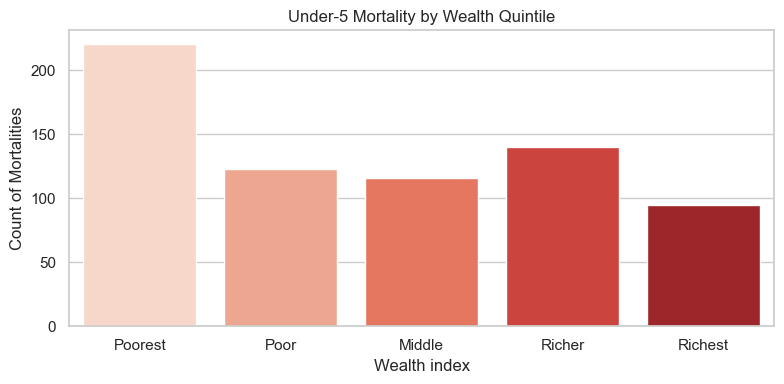

In [6]:
# Filter mortalities and make a safe copy
mortality_df = df[df['under5_mortality'] == 1].copy()

# Map numeric codes to readable labels
label_map = {1: "Poorest", 2: "Poor", 3: "Middle", 4: "Richer", 5: "Richest"}
mortality_df['Wealth_label'] = mortality_df['Wealth index combined'].map(label_map)

# Define desired order (so bars appear Poorest -> Richest)
order = [label_map[i] for i in sorted(label_map.keys())]

plt.figure(figsize=(8,4))
sns.countplot(x='Wealth_label', data=mortality_df, order=order, palette="Reds")
plt.title("Under-5 Mortality by Wealth Quintile")
plt.xlabel("Wealth index")
plt.ylabel("Count of Mortalities")
plt.tight_layout()
plt.show()


In the above chart, we can see that the highest mortality rate is in the 'poorest'(1) category, followed by the 'richer'(4) category, then the 'poor'(2) category, then the 'middle'(3) category and lastly the 'richest'(5) category. Interestingly enough, the 'richer'(4) category had the second-highest number of mortalities.

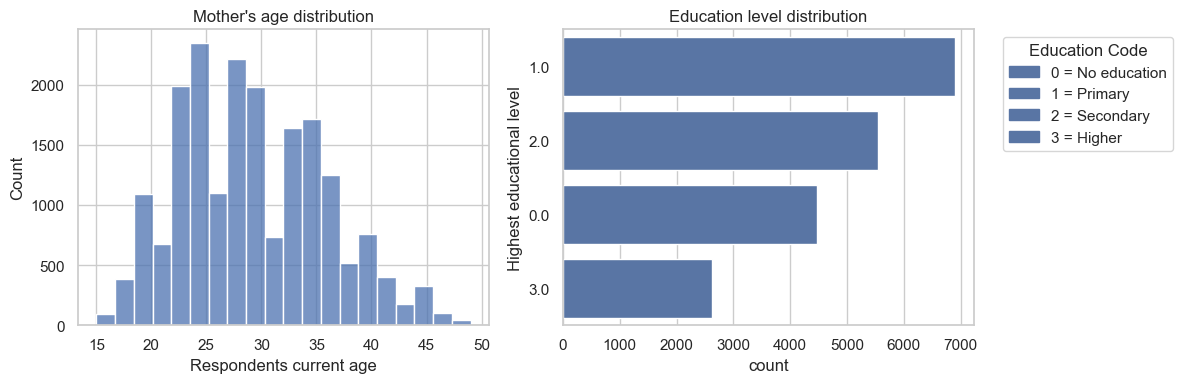

In [7]:
#Education Level and Age Distribution
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Age distribution
sns.histplot(df['Respondents current age'], bins=20, ax=axes[0], kde=False)
axes[0].set_title("Mother's age distribution")

# Education distribution
order = df['Highest educational level'].value_counts().index
barplot = sns.countplot(
    y='Highest educational level',
    data=df,
    order=order,
    ax=axes[1]
)
axes[1].set_title("Education level distribution")


# Custom legend with actual bar colors
legend_labels = {
    0: "No education",
    1: "Primary",
    2: "Secondary",
    3: "Higher"
}

# Get bar colors from the plot
colors = [p.get_facecolor() for p in barplot.patches]

# Create patches with matching colors
patches = [
    mpatches.Patch(color=colors[i], label=f"{code} = {label}")
    for i, (code, label) in enumerate(legend_labels.items())
]

axes[1].legend(handles=patches, title="Education Code", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


The visualization on the left shows the distribution of ages of the respondents. Most respondents are located between ages 22-35.
On the right, most respondents (35.3%) have an education level of primary school, followed by secondary school(28.4%), then no education(22.9%) and lastly tertiary education(13.5%).

## Maternal and ANC Factors' Analysis

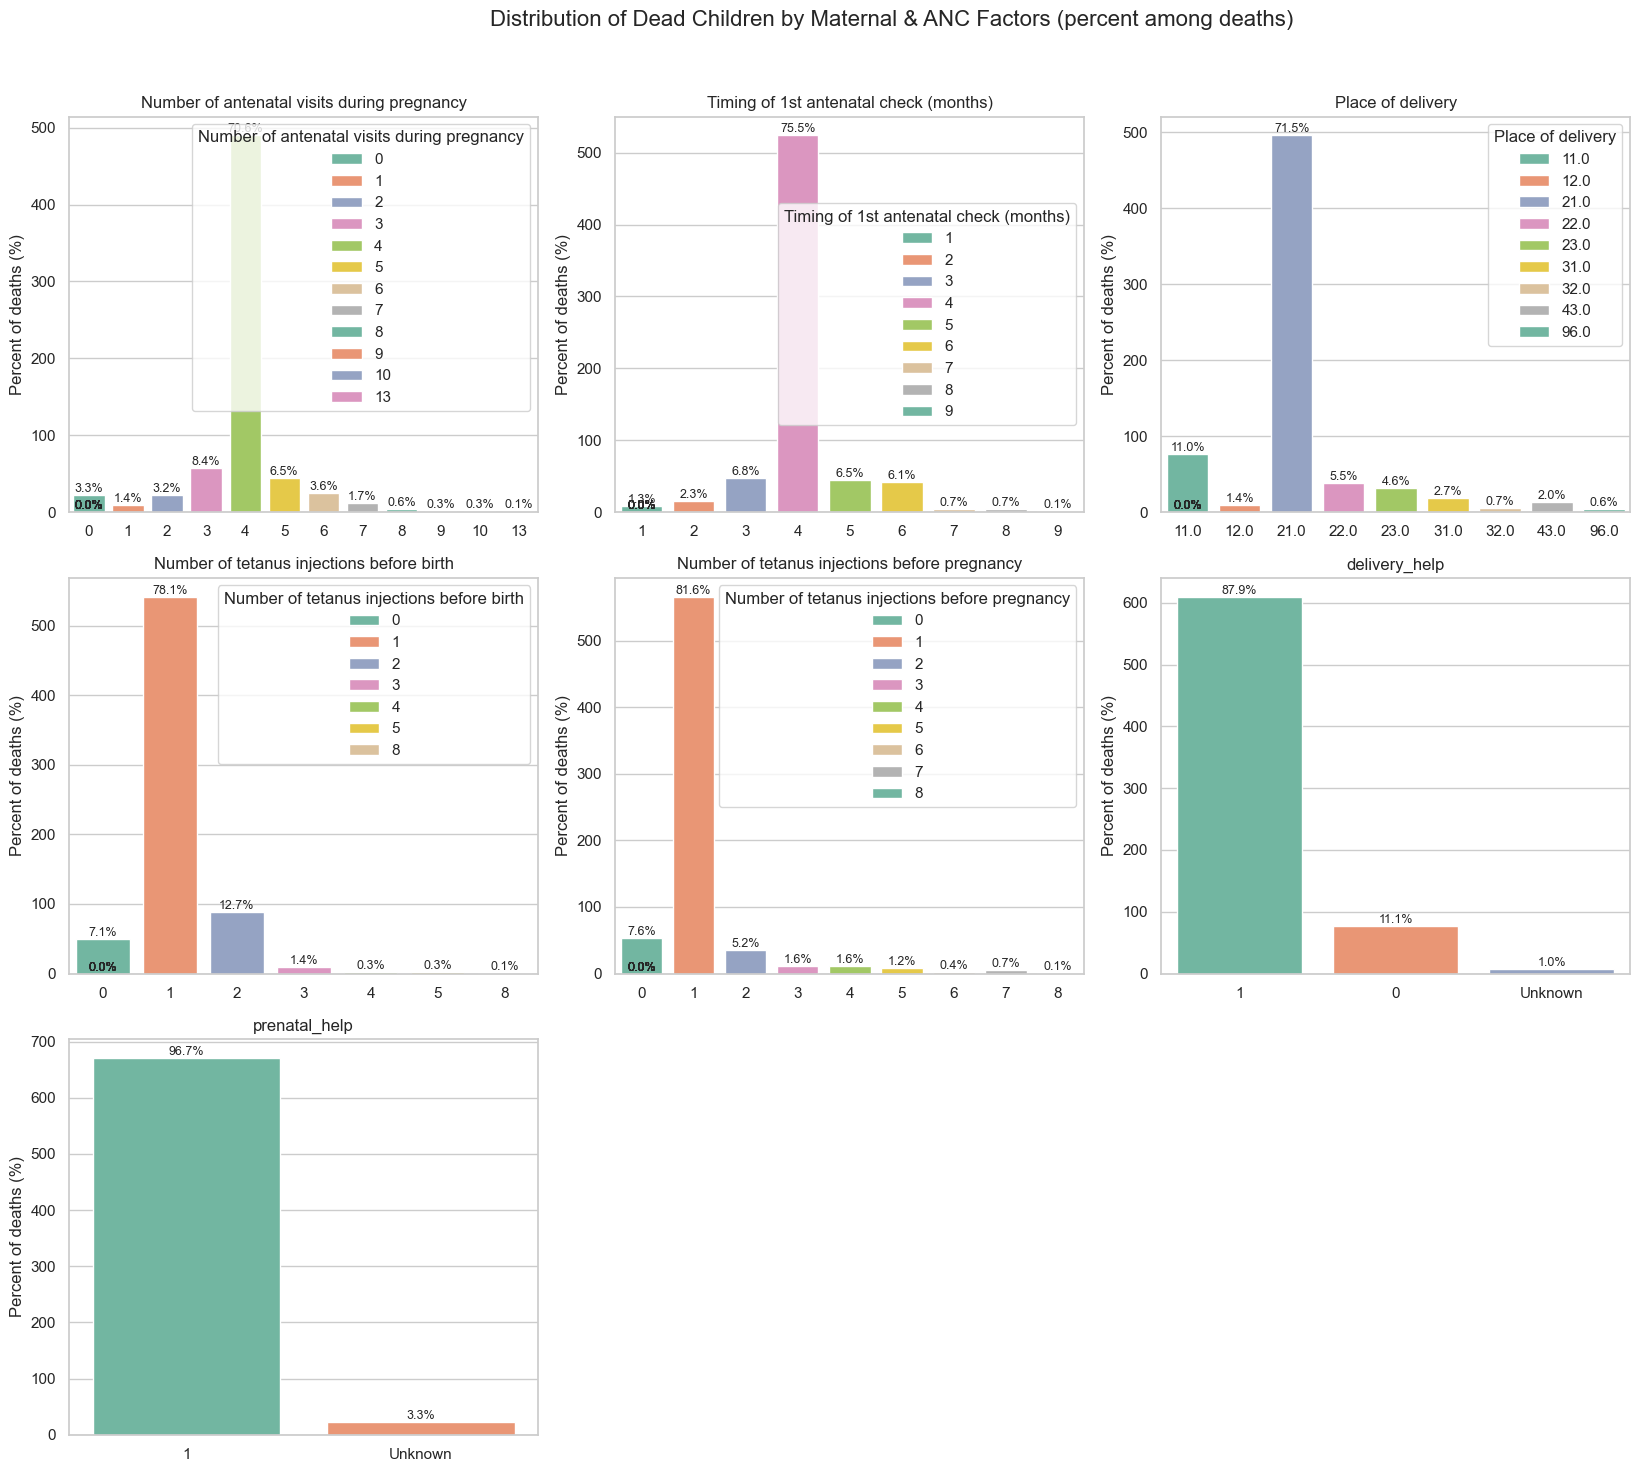

In [8]:
# Variables to include 
factors = [
    'Number of antenatal visits during pregnancy',
    'Timing of 1st antenatal check (months)',
    'Place of delivery',
    'Number of tetanus injections before birth',
    'Number of tetanus injections before pregnancy',
    'delivery_help',
    'prenatal_help'
]

# 3x3 grid
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(factors):
    ax = axes[i]
    
    # Countplot
    g = sns.countplot(
        data=df_dead,
        x=col,
        ax=ax,
        hue=col,  # fixes palette warning
        palette="Set2",
    )
    
    # Add percentages on top of bars
    total = len(df_dead)
    for p in ax.patches:
        percentage = 100 * p.get_height() / total
        ax.annotate(f'{percentage:.1f}%', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=9)
    
    ax.set_ylabel("Percent of deaths (%)")
    ax.set_xlabel("")
    ax.set_title(col)

# Remove empty subplots
for j in range(len(factors), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Distribution of Dead Children by Maternal & ANC Factors (percent among deaths)", 
             fontsize=16)
plt.tight_layout(rect=[0, 0, 0.92, 0.96])
plt.show()


**1. Number of ANC visits (0,1,2,3 vs. 4–7)**  
Intuitively: fewer ANC visits → higher mortality (less monitoring, fewer interventions).

But your plots show that most deaths are in the 4–7 group.

**Why?**  
Base rate effect: The majority of women in DHS attend 4+ visits (because WHO recommends it, and many programs encourage it).

So even if their individual risk is lower, the absolute number of deaths looks higher in this group simply because more children are born to women who had 4+ visits.

👉 That’s why descriptive barplots can look “illogical”: they don’t account for denominators.
To fix this, you’d need to compute mortality rates per category:

Mortality Rate=(Deaths in group/Total births in group)×1000

That way, you’d see that 0–3 visits have higher risk per 1000 births, but 4–7 visits still dominate in raw numbers.

Right now, your plots answer:
**“Where did most deaths occur?”**

But what you really want is:
**“Who is at greater risk of death?”**

That’s the mortality rate per category:

This adjusts for the fact that, for example, most women attend 4–7 ANC visits, so raw deaths will cluster there even if the risk is lower.

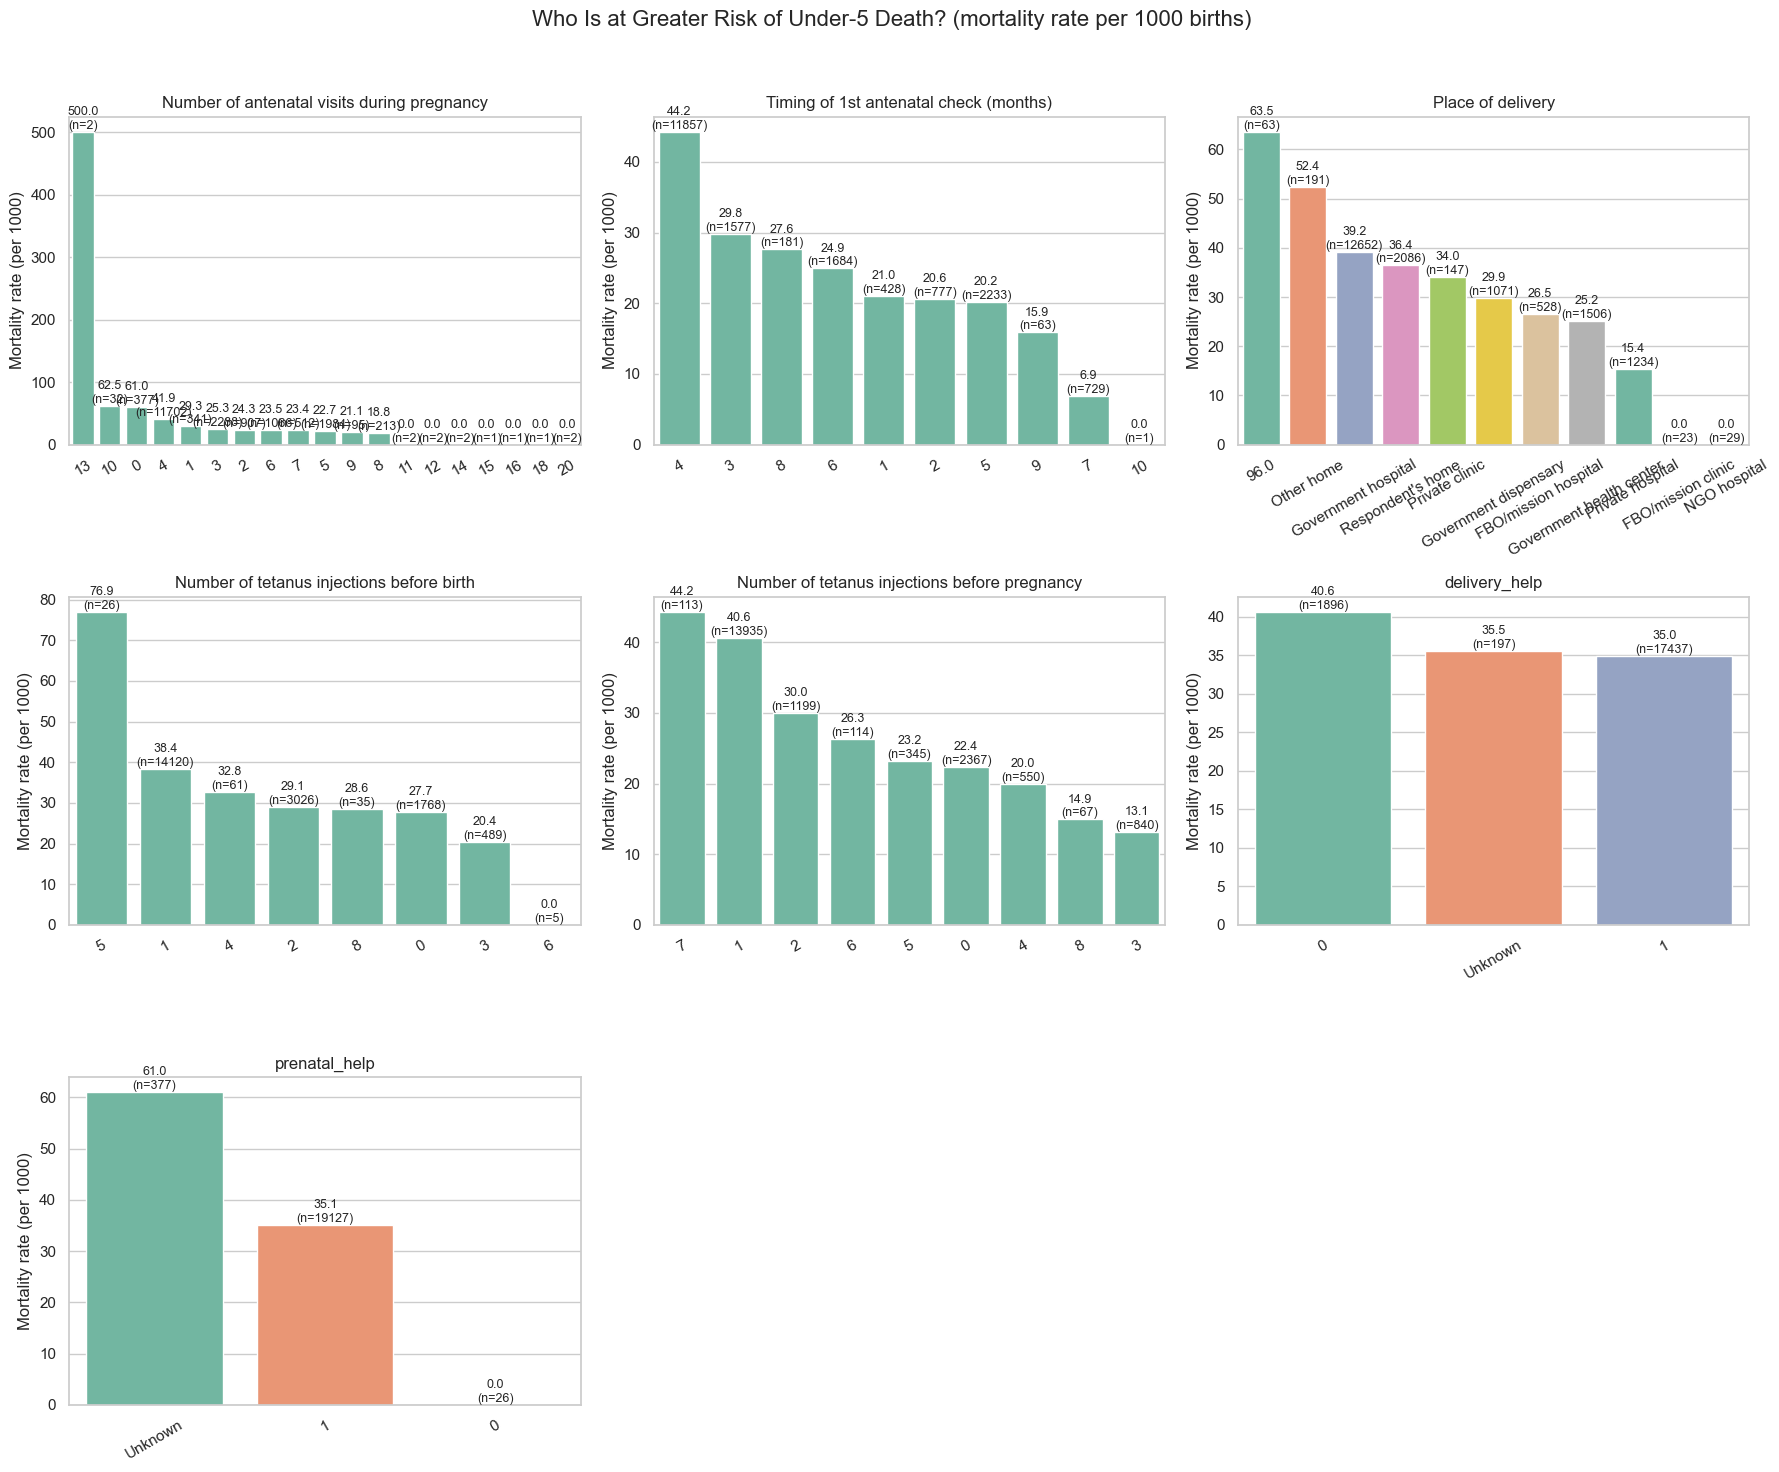

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api import types as pdtypes

# --- Map for place of delivery ---
place_labels = {
    10: "HOME",
    11: "Respondent's home",
    12: "Other home",
    20: "PUBLIC SECTOR",
    21: "Government hospital",
    22: "Government health center",
    23: "Government dispensary",
    26: "Other public sector",
    30: "PRIVATE MEDICAL SECTOR",
    31: "Private hospital",
    32: "Private clinic",
    36: "Other private medical sector",
    40: "NGO SECTOR",
    41: "NGO hospital",
    42: "NGO clinic",
    43: "FBO/mission hospital",
    44: "FBO/mission clinic",
    46: "Other NGO medical sector",
    47: "Other FBO medical sector"
}
# Map codes to labels; keep unmapped codes as string of the code
df['Place of delivery'] = df['Place of delivery'].map(place_labels).fillna(df['Place of delivery'].astype(str))

# Map for prenatal and delivery labor
labels = {
    0: "Untrained Labor",
    1: "Trained Labor"
}

df['prenatal_help'] = df['prenatal_help'].map(labels).fillna(df['prenatal_help'].astype(str))
df['delivery_help'] = df['delivery_help'].map(labels).fillna(df['delivery_help'].astype(str))


# --- Target setup ---
target = 'under5_mortality'
df = df.copy()
df[target] = pd.to_numeric(df[target], errors='coerce')
df = df[~df[target].isna()]


# --- Factors to plot (no birth interval categories) ---
factors = [
    'Number of antenatal visits during pregnancy',
    'Timing of 1st antenatal check (months)',
    'Place of delivery',
    'Number of tetanus injections before birth',
    'Number of tetanus injections before pregnancy',
    'delivery_help',
    'prenatal_help'
]

# Clean known missing codes
for col in factors:
    if col in df.columns:
        df[col] = df[col].replace({-9: np.nan, -99: np.nan, '': np.nan})

# --- Plotting: 3x3 grid, legends handled separately ---
sns.set(style='whitegrid')
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for i, col in enumerate(factors):
    ax = axes[i]
    if col not in df.columns:
        ax.text(0.5, 0.5, f'Column not found:\n{col}', ha='center', va='center', fontsize=12)
        ax.set_axis_off()
        continue

    # Compute mortality rates per category
    rate_df = (
        df.groupby(col)[target]
        .agg(sum_deaths='sum', n='count')
        .reset_index()
    )
    rate_df['mortality_rate'] = rate_df['sum_deaths'] / rate_df['n'] * 1000
    rate_df = rate_df.sort_values('mortality_rate', ascending=False)

    # Determine if the variable is numeric; if numeric, DO NOT set hue or pass palette
    is_numeric = pdtypes.is_numeric_dtype(df[col]) or pdtypes.is_integer_dtype(df[col])
    order = rate_df[col].tolist()

    if is_numeric:
        # For numeric variables: no hue, no palette passed to avoid FutureWarning
        sns.barplot(
            data=rate_df,
            x=col,
            y='mortality_rate',
            dodge=False,
            ax=ax,
            order=order,
            color=sns.color_palette("Set2")[0]  # single color for numeric plots
        )
    else:
        # Categorical: set hue equal to x (categorical) to allow palette usage without warning
        sns.barplot(
            data=rate_df,
            x=col,
            y='mortality_rate',
            hue=col,
            dodge=False,
            palette='Set2',
            ax=ax,
            order=order
        )
        # move the legend for this axis to the right, outside the plot
        handles, labels = ax.get_legend_handles_labels()
        if handles:
            # remove the automatic legend then place a cleaned legend outside
            ax.legend_.remove()
            ax.legend(handles, labels, bbox_to_anchor=(1.02, 0.95), loc='upper left', borderaxespad=0., frameon=True, fontsize=9)

    # Annotate bars with rate and sample size
    for p, (_, r) in zip(ax.patches, rate_df.iterrows()):
        height = p.get_height()
        ax.annotate(f'{height:.1f}\n(n={int(r["n"])})',
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9)

    ax.set_ylabel("Mortality rate (per 1000)")
    ax.set_xlabel("")
    ax.set_title(col)
    ax.tick_params(axis='x', rotation=30)

# Remove any unused axes
for j in range(len(factors), len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Who Is at Greater Risk of Under-5 Death? (mortality rate per 1000 births)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


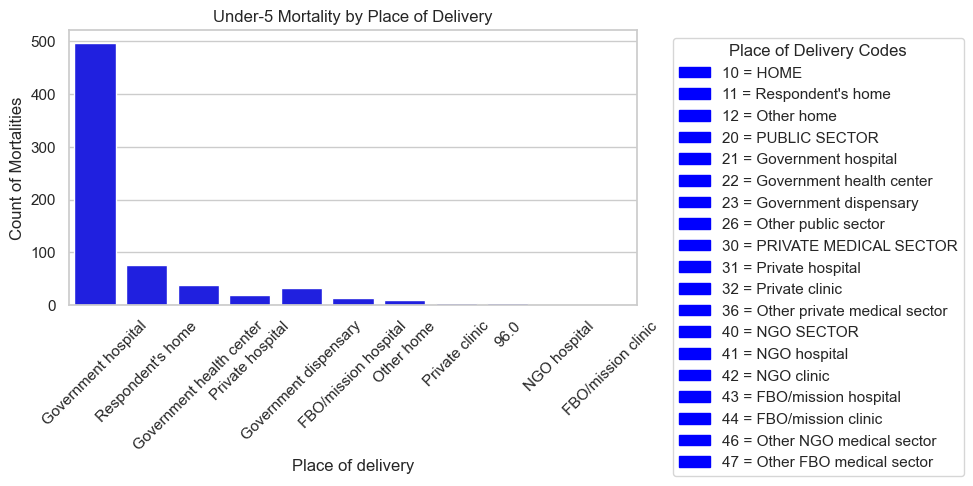

In [10]:
# Filter only mortalities
mortality_df = df[df['under5_mortality'] == 1].copy()

# Mapping of codes to labels
place_labels = {
    10: "HOME",
    11: "Respondent's home",
    12: "Other home",
    20: "PUBLIC SECTOR",
    21: "Government hospital",
    22: "Government health center",
    23: "Government dispensary",
    26: "Other public sector",
    30: "PRIVATE MEDICAL SECTOR",
    31: "Private hospital",
    32: "Private clinic",
    36: "Other private medical sector",
    40: "NGO SECTOR",
    41: "NGO hospital",
    42: "NGO clinic",
    43: "FBO/mission hospital",
    44: "FBO/mission clinic",
    46: "Other NGO medical sector",
    47: "Other FBO medical sector"
}

plt.figure(figsize=(10,5))
ax = sns.countplot(
    x='Place of delivery',
    data=mortality_df,
    order=df['Place of delivery'].value_counts().index,
    color="blue"
)

plt.title("Under-5 Mortality by Place of Delivery")
plt.xticks(rotation=45)
plt.ylabel("Count of Mortalities")
plt.xlabel("Place of delivery")

# --- Build legend patches ---
patches = [
    mpatches.Patch(color="blue", label=f"{code} = {label}")
    for code, label in place_labels.items()
]

plt.legend(
    handles=patches,
    title="Place of Delivery Codes",
    bbox_to_anchor=(1.05, 1),
    loc='upper left'
)

plt.tight_layout()
plt.show()


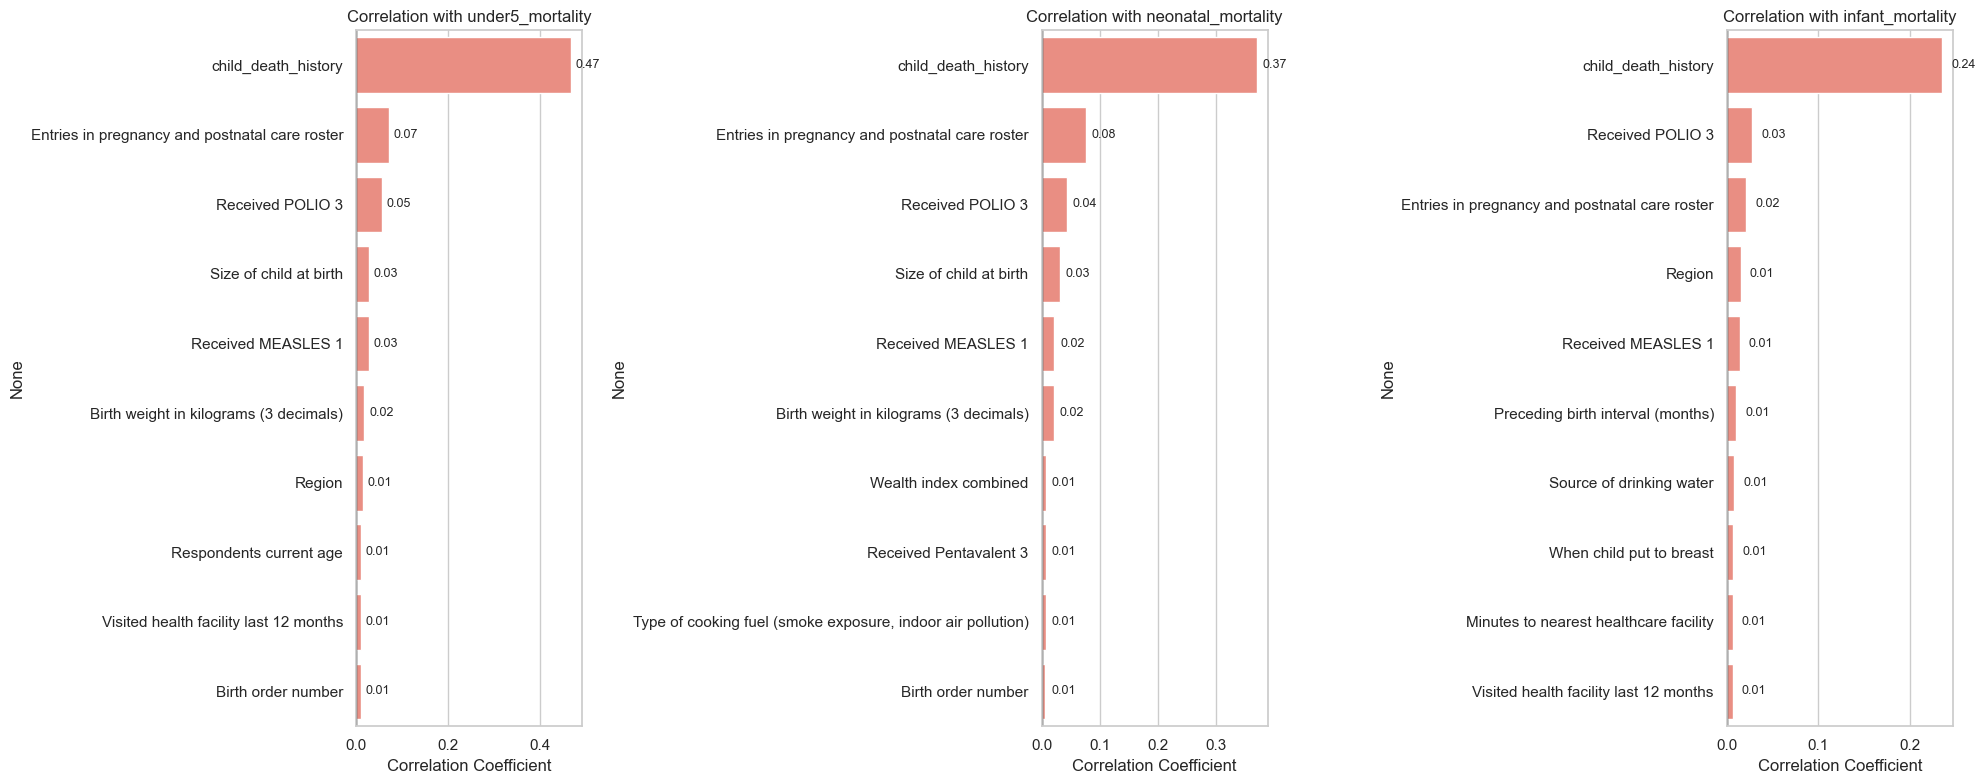

In [11]:
# base numeric columns excluding *_missing flags
base_numeric = [
    c for c in df.select_dtypes(include=['float64','int64']).columns
    if not c.endswith('_missing')
]

targets = ['under5_mortality','neonatal_mortality','infant_mortality']

fig, axes = plt.subplots(1, 3, figsize=(20,8))

for ax, target in zip(axes, targets):
    # exclude the other two targets
    numeric_cols = [c for c in base_numeric if c not in targets or c == target]
    corr = (
        df[numeric_cols]
        .corr()[target]
        .drop(target)
        .sort_values(ascending=False).head(10)
    )

    sns.barplot(x=corr.values, y=corr.index, ax=ax, color='salmon')
    ax.set_title(f"Correlation with {target}")
    ax.set_xlabel("Correlation Coefficient")
    ax.axvline(0, color='black', lw=1)

    # --- Add data labels on each bar
    for i, v in enumerate(corr.values):
        ax.text(v + (0.01 if v>=0 else -0.01), i, f"{v:.2f}",
                va='center', ha='left' if v>=0 else 'right', fontsize=9)

plt.tight_layout()
plt.show()


## Child Health and Nutrition Factors
- Duration of breastfeeding
- Time when child was put to breast
- Anthropometry 


## Immunization/Vaccination factors
- BCG
- Pentavalent
- PNEUMOCOCCAL
- Measles
- Yellow fever
- Polio


Vaccination-related columns found:
 ['Received BCG', 'Received POLIO 1', 'Received POLIO 2', 'Received POLIO 3', 'Received POLIO 0', 'Received MEASLES 1', 'Received MEASLES 2', 'Received Pentavalent 1', 'Received Pentavalent 2', 'Received Pentavalent 3', 'Received Pneumococcal 1', 'Received Pneumococcal 2', 'Received Pneumococcal 3', 'Received inactivated polio (IPV)', 'Yellow fever vaccine', 'Received BCG_missing', 'Received POLIO 1_missing', 'Received POLIO 2_missing', 'Received POLIO 3_missing', 'Received POLIO 0_missing', 'Received MEASLES 1_missing', 'Received MEASLES 2_missing', 'Received Pentavalent 1_missing', 'Received Pentavalent 2_missing', 'Received Pentavalent 3_missing', 'Received Pneumococcal 1_missing', 'Received Pneumococcal 2_missing', 'Received Pneumococcal 3_missing', 'Received inactivated polio (IPV)_missing', 'Yellow fever vaccine_missing', 'bcg', 'measles', 'polio', 'pentavalent', 'pneumococcal', 'yellow_fever']


C:\Users\user\AppData\Local\Temp\ipykernel_2260\2036049774.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rate_df, x=vaccine, y='mortality_rate', ax=ax, palette='Set2')
C:\Users\user\AppData\Local\Temp\ipykernel_2260\2036049774.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rate_df, x=vaccine, y='mortality_rate', ax=ax, palette='Set2')
C:\Users\user\AppData\Local\Temp\ipykernel_2260\2036049774.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=rate_df, x=vaccine, y='mortality_rate', ax=ax, palette='Set2')
C:\User

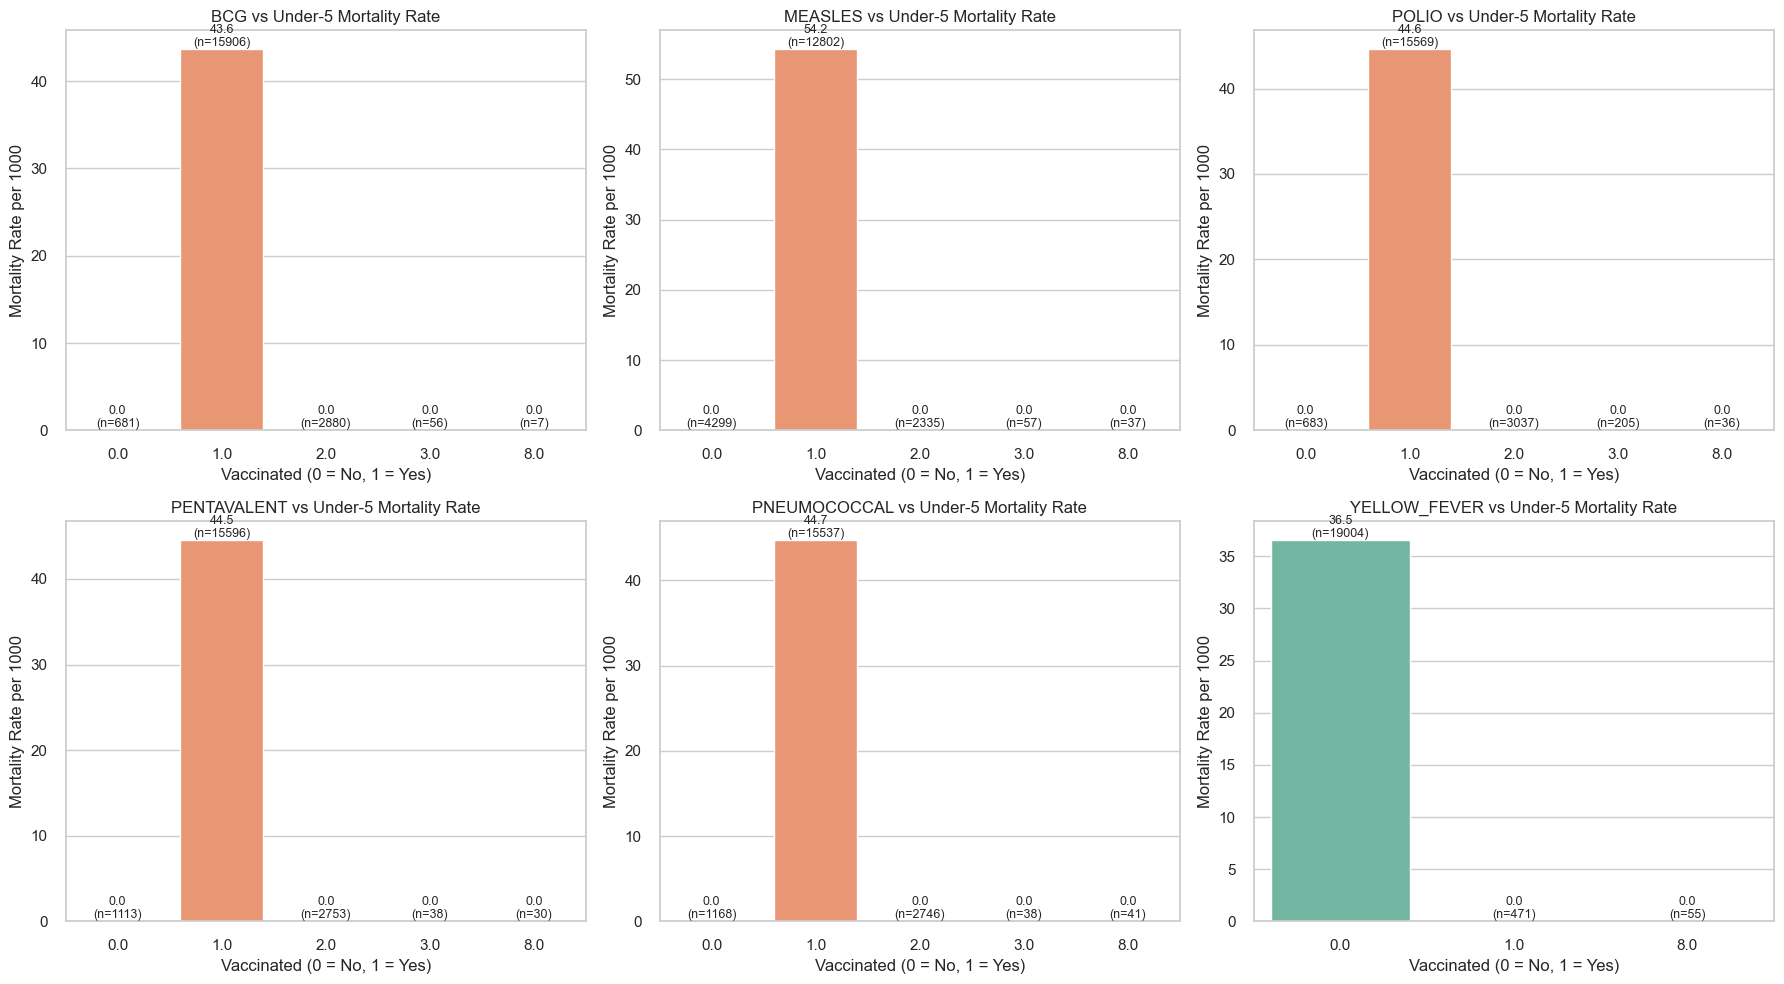

In [14]:
# 1. Identify vaccination-related columns by keyword
vacc_cols = [col for col in df.columns if any(v in col.lower() for v in ['bcg', 'pent', 'measles', 'pneumo', 'yellow', 'polio'])]
print("Vaccination-related columns found:\n", vacc_cols)

# 2. Combine multiple vaccine dose columns into binary columns
df['bcg'] = df['Received BCG']
df['measles'] = df[['Received MEASLES 1', 'Received MEASLES 2']].max(axis=1)
df['polio'] = df[
    ['Received POLIO 0', 'Received POLIO 1', 'Received POLIO 2', 'Received POLIO 3', 'Received inactivated polio (IPV)']
].max(axis=1)
df['pentavalent'] = df[
    ['Received Pentavalent 1', 'Received Pentavalent 2', 'Received Pentavalent 3']
].max(axis=1)
df['pneumococcal'] = df[
    ['Received Pneumococcal 1', 'Received Pneumococcal 2', 'Received Pneumococcal 3']
].max(axis=1)
df['yellow_fever'] = df['Yellow fever vaccine']

# 3. Define vaccine columns and mortality outcome column
vaccines = ['bcg', 'measles', 'polio', 'pentavalent', 'pneumococcal', 'yellow_fever']
target = 'under5_mortality'  # You should have defined this earlier based on age at death < 60 months

# 4. Plot setup
sns.set(style='whitegrid')
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, vaccine in enumerate(vaccines):
    ax = axes[i]

    # 5. Subset and drop missing
    subset = df[[vaccine, target]].dropna()

    # Handle case where only one category exists or data missing
    if subset.empty or subset[vaccine].nunique() < 2:
        ax.text(0.5, 0.5, "Not enough data", ha='center', va='center', fontsize=12)
        ax.set_axis_off()
        continue

    # 6. Group by vaccination status and calculate mortality rate
    rate_df = subset.groupby(vaccine)[target].agg(
        deaths='sum',
        total='count'
    ).reset_index()
    rate_df['mortality_rate'] = rate_df['deaths'] / rate_df['total'] * 1000

    # 7. Plot
    sns.barplot(data=rate_df, x=vaccine, y='mortality_rate', ax=ax, palette='Set2')

    # 8. Annotate bars
    for p, row in zip(ax.patches, rate_df.itertuples()):
        height = p.get_height()
        ax.annotate(f"{height:.1f}\n(n={int(row.total)})", 
                    (p.get_x() + p.get_width()/2., height), 
                    ha='center', va='bottom', fontsize=9)

    # 9. Titles and labels
    ax.set_title(f"{vaccine.upper()} vs Under-5 Mortality Rate")
    ax.set_xlabel("Vaccinated (0 = No, 1 = Yes)")
    ax.set_ylabel("Mortality Rate per 1000")

# Final layout
plt.tight_layout()
plt.show()

## Healthcare access
- Distance
- Transport
- Number of facility visits

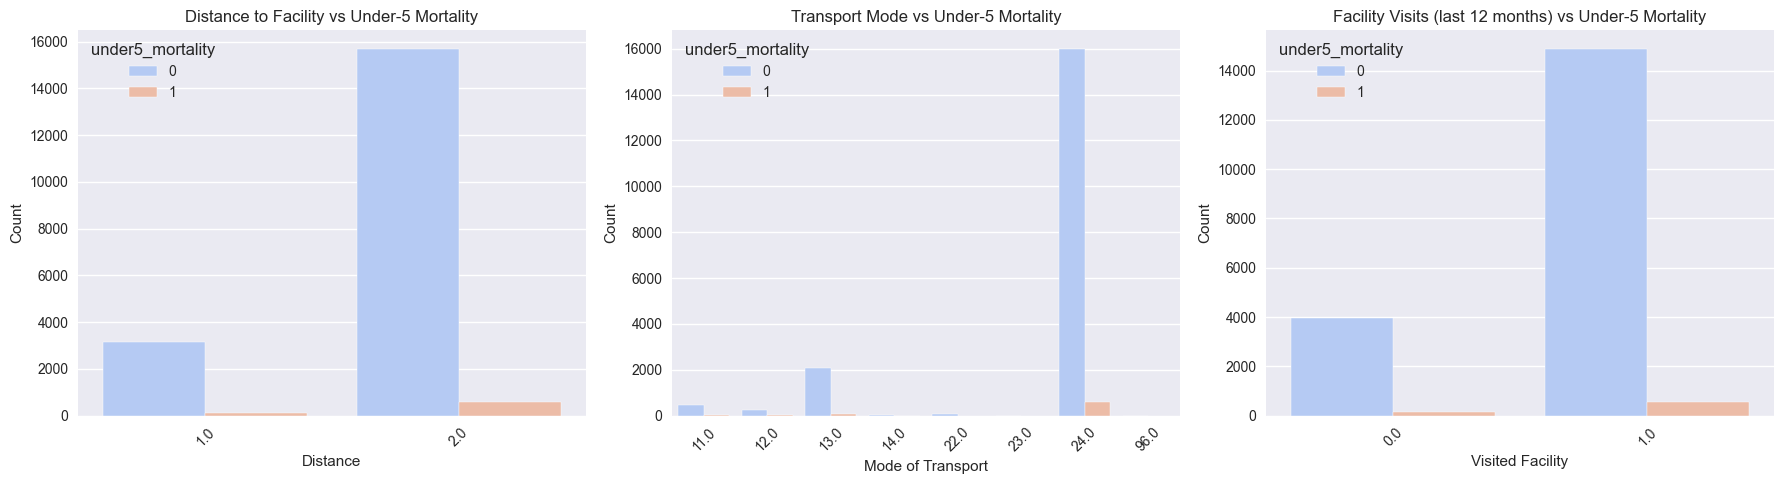

In [13]:
# --- make sure these match your column names ---
dist_col = "Getting medical help for self: distance to health facility"
transport_col = "Mode of transportation to nearest healthcare facility"
visit_col = "Visited health facility last 12 months"
target_col = "under5_mortality"

plt.style.use("seaborn-v0_8")
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# 1️⃣ Distance vs under-5 mortality
sns.countplot(
    data=df,
    x=dist_col,
    hue=target_col,
    palette="coolwarm",
    ax=axes[0]
)
axes[0].set_title("Distance to Facility vs Under-5 Mortality")
axes[0].set_xlabel("Distance")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x', rotation=45)

# 2️⃣ Transport vs under-5 mortality
sns.countplot(
    data=df,
    x=transport_col,
    hue=target_col,
    palette="coolwarm",
    ax=axes[1]
)
axes[1].set_title("Transport Mode vs Under-5 Mortality")
axes[1].set_xlabel("Mode of Transport")
axes[1].set_ylabel("Count")
axes[1].tick_params(axis='x', rotation=45)

# 3️⃣ Facility visits vs under-5 mortality
sns.countplot(
    data=df,
    x=visit_col,
    hue=target_col,
    palette="coolwarm",
    ax=axes[2]
)
axes[2].set_title("Facility Visits (last 12 months) vs Under-5 Mortality")
axes[2].set_xlabel("Visited Facility")
axes[2].set_ylabel("Count")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
